In [41]:
from pathlib import Path
import os
import json
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from gym_recording_modified.playback import get_recordings
from utils.data_extractors import *
from utils.visualizations import *
import seaborn as sns
from scipy.stats import sem
from scipy.signal import convolve2d

In [79]:
root = Path('results_new_sweep')
params, num_episodes = extract_num_episodes(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'])

In [87]:
df1 = pd.DataFrame(params)
df2 = pd.DataFrame(num_episodes)
df = pd.concat([df1, df2], axis=1)
df.columns = ['Model', 'Env', 'Seed', 'Learning Freq.', 'Target Update Freq.', 'L', 'Step Size', 'Buffer Size', 
'Num Episodes']
df = df.drop(['Seed'],axis=1)
df['Algorithm'] = df['Model'] + ', ' + df['L'] 
df = df.drop(['Model', 'L' ], axis=1)

columns = ['Algorithm', 'Env', 'Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'] #parameters

# rename environments
df = df.replace('envs:random_maze-v0', 'Maze')

# rename Algorithms
df = df.replace('FFN, 10', 'FFN')

(10800, 9)
(10800, 7)


In [81]:
df_mean = df.groupby(columns).mean().reset_index() # dataframe with mean over seeds for each parameter/alg/env configuration

# Total Number of episodes completed for all hyperparameters

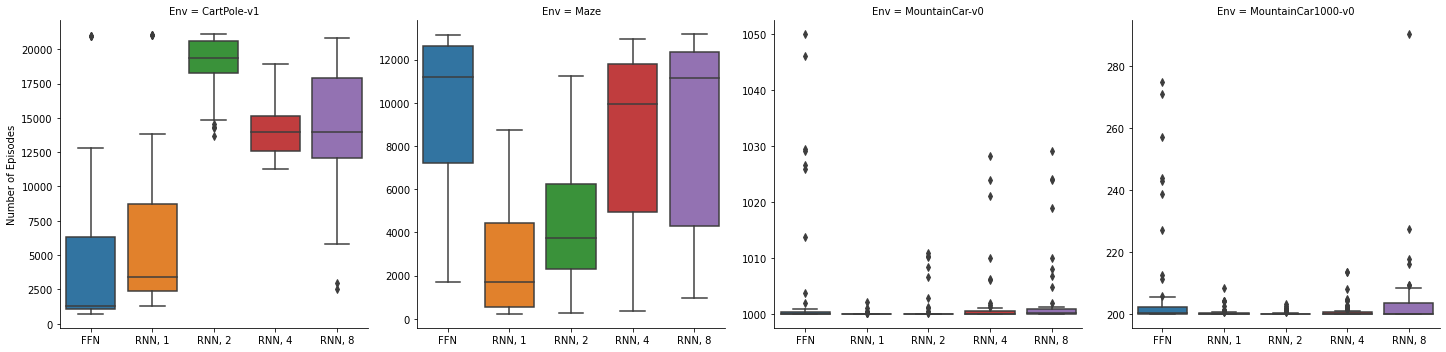

In [88]:
# Box plots of average number of episodes completed for all algorithms
g = sns.catplot(x='Algorithm', y='Num Episodes', col='Env', data=df_mean, kind='box', sharey=False)
g.set_axis_labels("", "Number of Episodes")
plt.savefig('figures/sensitivity.pdf', bbox_inches='tight')

In [15]:
def n_best_params(df, env, alg, n, columns, metric, maximize=True):
    '''
    returns the n best hyperparameter of alg on env accroding to metric column in df
    if maximize = True then higher numbers are better
    '''
    df_env_alg = df.loc[(df['Env'] == env) & (df['Algorithm'] ==alg)] # filtered by env and alg
    if maximize:
        df_env_alg = df_env_alg.nlargest(n, metric)
    else:
        df_env_alg = df_env_alg.nsmallest(n, metric)

    df_env_alg = df_env_alg.set_index(columns)
    inds = df_env_alg.index.tolist()

    return inds

In [16]:
def get_best_data(df, df_mean, columns, metric):
    '''
    Filters a dataframe to only include data from the best hyperparameters, as determined by df_mean
    '''
    inds = []
    for env in df['Env'].unique():
        for alg in df['Algorithm'].unique():
            if env == 'CartPole-v1': # fewer episodes completed is better for cartpole
                maximize = False
            else:
                maximize = True

            inds += n_best_params(df_mean, env, alg, 1, columns, metric, maximize=maximize)
    
    df_ = df.set_index(columns)
    df_ = df_.loc[inds]
    return df_.reset_index()

## Total Number of episodes completed for best hyperparameters

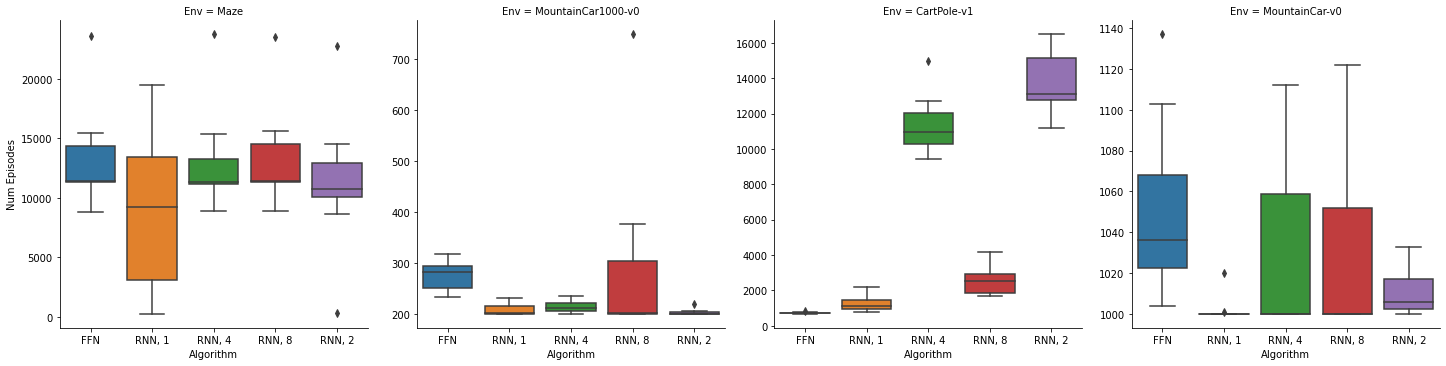

In [16]:
df_best = get_best_data(df, df_mean, columns, 'Num Episodes')
g = sns.catplot(x='Algorithm', y='Num Episodes', col='Env', data=df_best, kind='box', sharey=False)
plt.savefig('figures/total_episodes_best_params.pdf', bbox_inches='tight')

## Total Number of episodes completed for best hyperparameters last 10 episodes

In [15]:
root = Path('results_new_sweep')
params, num_episodes = extract_epsisode_lengths(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'], last_n=10)

num_episodes = np.mean(num_episodes, axis=1)

df1 = pd.DataFrame(params)
df2 = pd.DataFrame(num_episodes)
df_last = pd.concat([df1, df2], axis=1)
df_last.columns = ['Model', 'Env', 'Seed', 'Learning Freq.', 'Target Update Freq.', 'L', 'Step Size', 'Buffer Size', 
'Average Episode Length']
df_last = df_last.drop(['Seed'],axis=1)
df_last['Algorithm'] = df_last['Model'] + ', ' + df_last['L'] 
df_last = df_last.drop(['Model', 'L' ], axis=1)

columns = ['Algorithm', 'Env', 'Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'] #parameters

# rename environments
df_last = df_last.replace('envs:random_maze-v0', 'Maze')

# rename Algorithms
df_last = df_last.replace('FFN, 10', 'FFN')

10800it [00:05, 1917.18it/s]


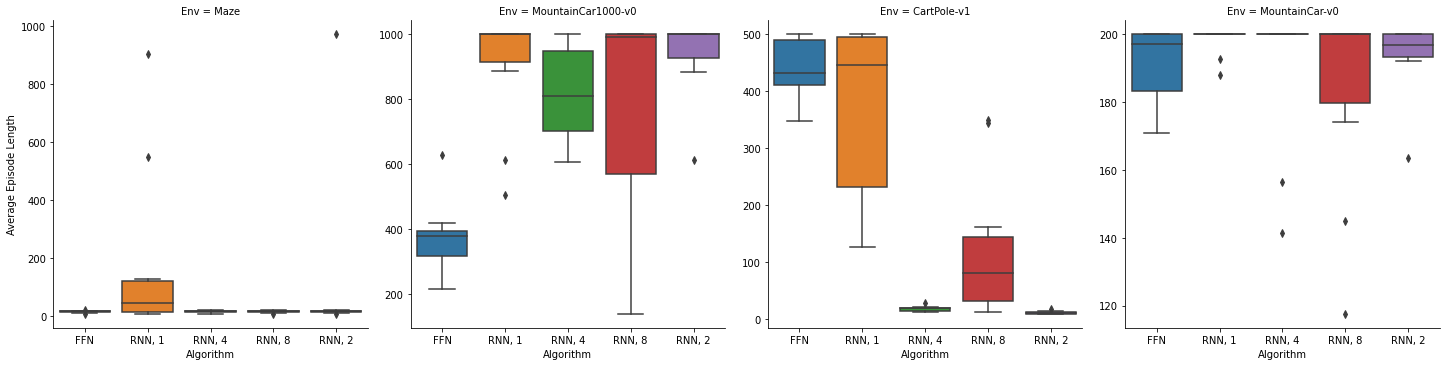

In [17]:
df_best_last = get_best_data(df_last, df_mean, columns, 'Num Episodes') # performance metric for determining best parameters is still num episodes
g = sns.catplot(x='Algorithm', y='Average Episode Length', col='Env', data=df_best_last, kind='box', sharey=False)
plt.savefig('figures/last_10_length_best_params.pdf', bbox_inches='tight')

# LSTM Results

## Total Number of episodes completed for all hyperparameters

In [70]:
root = Path('results_lstm')
params, num_episodes = extract_num_episodes(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'])

df1 = pd.DataFrame(params)
df2 = pd.DataFrame(num_episodes)
df = pd.concat([df1, df2], axis=1)
df.columns = ['Model', 'Env', 'Seed', 'Learning Freq.', 'Target Update Freq.', 'L', 'Step Size', 'Buffer Size', 
'Num Episodes']
df = df.drop(['Seed'],axis=1)
df['Algorithm'] = df['Model'] + ', ' + df['L'] 
df = df.drop(['Model', 'L' ], axis=1)

columns = ['Algorithm', 'Env', 'Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'] #parameters

# rename environments
df = df.replace('envs:random_maze-v0', 'Maze')
df = df.replace('RNN', 'LSTM')

In [73]:
df

,Env,Learning Freq.,Target Update Freq.,Step Size,Buffer Size,Num Episodes,Algorithm
0,Maze,100,1000,0.005,100000,2640,"RNN, 4"
1,Maze,10,100,0.005,100000,11941,"RNN, 2"
2,Maze,10,1000,5e-05,100000,294,"RNN, 1"
3,MountainCar1000-v0,10,1000,0.0005,10000,200,"RNN, 1"
4,MountainCar1000-v0,100,1000,5e-05,10000,200,"RNN, 8"
...,...,...,...,...,...,...,...
8635,MountainCar-v0,1,1,5e-05,10000,1006,"RNN, 4"
8636,Maze,10,100,0.005,10000,13885,"RNN, 4"
8637,CartPole-v1,1,1000,5e-05,100000,3513,"RNN, 4"
8638,MountainCar-v0,100,1000,5e-05,100000,1000,"RNN, 1"


In [71]:
df_mean = df.groupby(columns).mean().reset_index()

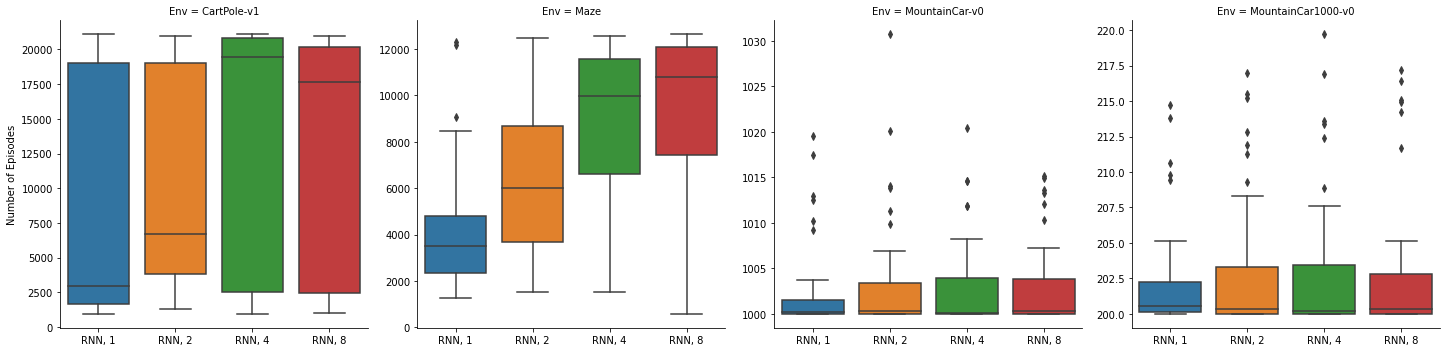

In [76]:
g = sns.catplot(x='Algorithm', y='Num Episodes', col='Env', data=df_mean, kind='box', sharey=False)
g.set_axis_labels("", "Number of Episodes")
plt.savefig('figures/sensitivity_lstm.pdf', bbox_inches='tight')

## Total Number of episodes completed for best hyperparameters

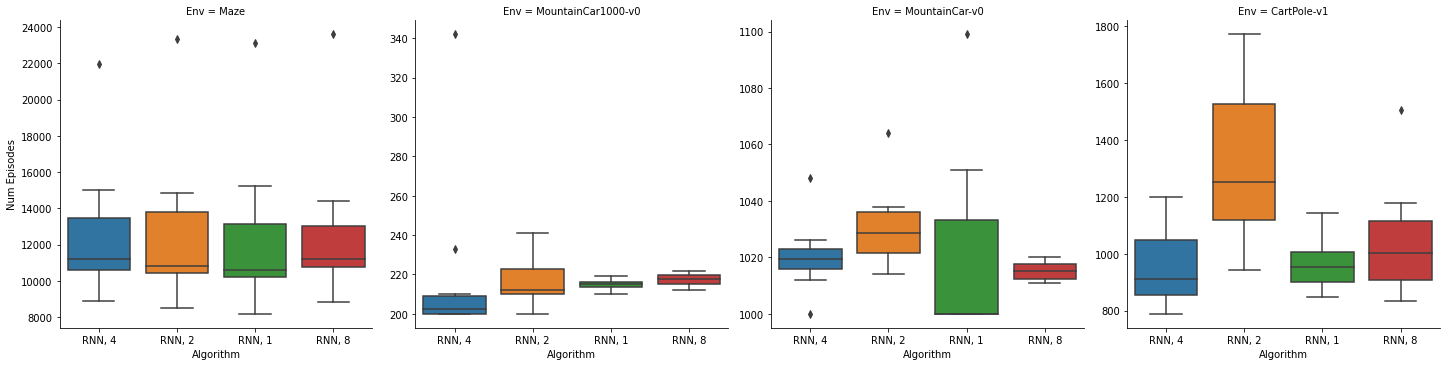

In [66]:
df_best = get_best_data(df, df_mean, columns, 'Num Episodes')
g = sns.catplot(x='Algorithm', y='Num Episodes', col='Env', data=df_best, kind='box', sharey=False)
plt.savefig('figures/total_episodes_best_params_lstm.pdf', bbox_inches='tight')

## Average Episode Length for best hyperparameters last 10 episodes

In [42]:
params, num_episodes = extract_episode_lengths(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'], last_n=10)

In [52]:
means = num_episodes.mean(axis=1)

In [67]:
root = Path('results_lstm')
params, num_episodes = extract_episode_lengths(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'], last_n=10)

num_episodes = np.mean(num_episodes, axis=1)

df1 = pd.DataFrame(params)
df2 = pd.DataFrame(num_episodes)
df_last = pd.concat([df1, df2], axis=1)
df_last.columns = ['Model', 'Env', 'Seed', 'Learning Freq.', 'Target Update Freq.', 'L', 'Step Size', 'Buffer Size', 
'Average Episode Length']
df_last = df_last.drop(['Seed'],axis=1)
df_last['Algorithm'] = df_last['Model'] + ', ' + df_last['L'] 
df_last = df_last.drop(['Model', 'L' ], axis=1)

columns = ['Algorithm', 'Env', 'Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'] #parameters

# rename environments
df_last = df_last.replace('envs:random_maze-v0', 'Maze')

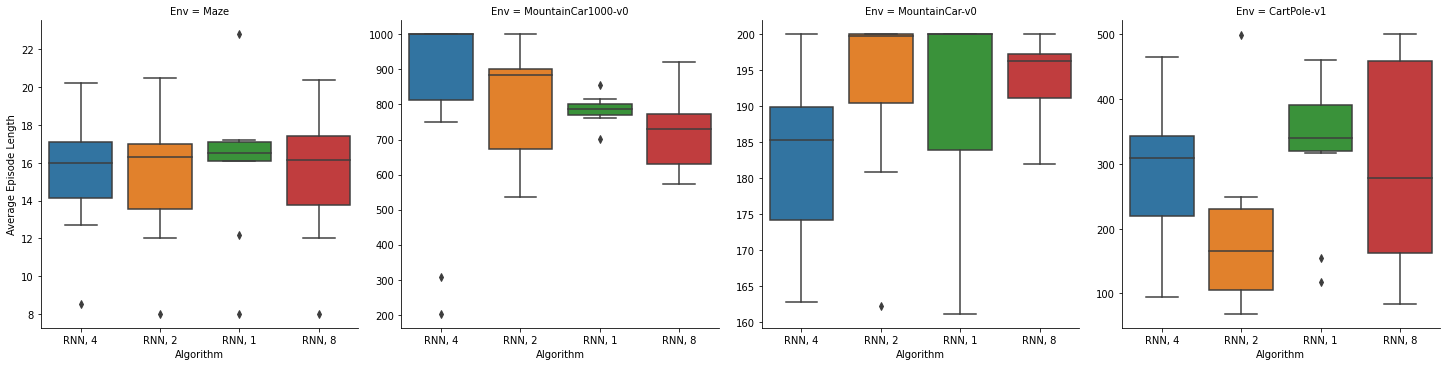

In [68]:
df_best_last = get_best_data(df_last, df_mean, columns, 'Num Episodes') # performance metric for determining best parameters is still num episodes
g = sns.catplot(x='Algorithm', y='Average Episode Length', col='Env', data=df_best_last, kind='box', sharey=False)
plt.savefig('figures/last_10_length_best_params_lstm.pdf', bbox_inches='tight')

In [35]:
%load_ext autoreload
%autoreload 2

In [90]:
root = Path('results_lstm')
params, num_episodes = extract_num_episodes(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'])

df1 = pd.DataFrame(params)
df2 = pd.DataFrame(num_episodes)
df_lstm = pd.concat([df1, df2], axis=1)
df_lstm = df_lstm.replace('RNN', 'LSTM')

root = Path('results_new_sweep')
params, num_episodes = extract_num_episodes(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'])

df1 = pd.DataFrame(params)
df2 = pd.DataFrame(num_episodes)
df_rnn = pd.concat([df1, df2], axis=1)

df = pd.concat([df_lstm, df_rnn])

df.columns = ['Model', 'Env', 'Seed', 'Learning Freq.', 'Target Update Freq.', 'L', 'Step Size', 'Buffer Size', 
'Num Episodes']
df = df.drop(['Seed'],axis=1)
df['Algorithm'] = df['Model'] + ', ' + df['L'] 
df = df.drop(['Model', 'L' ], axis=1)

columns = ['Algorithm', 'Env', 'Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'] #parameters

# rename environments
df = df.replace('envs:random_maze-v0', 'Maze')

# rename Algorithms
df_rnn = df.replace('FFN, 10', 'FFN')

In [98]:
df_mean = df.groupby(columns).mean().reset_index()

# Updated Plots

## Total Number of episodes completed for all hyperparameters

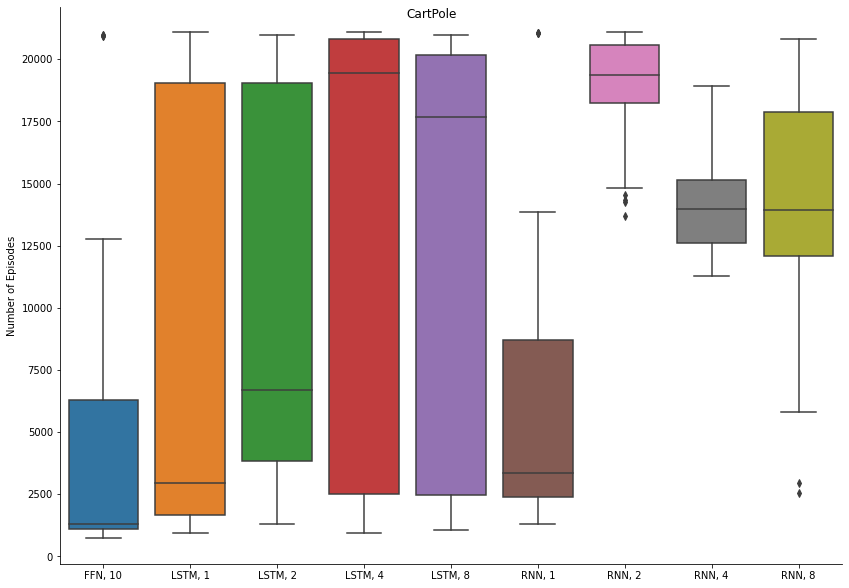

In [109]:
g = sns.catplot(x='Algorithm', y='Num Episodes', data=df_mean[df_mean['Env']=='CartPole-v1'], kind='box', sharey=False, height=8.27, aspect=11.7/8.27)
g.set_axis_labels("", "Number of Episodes")
g.fig.suptitle('CartPole')
plt.savefig('figures/sensitivity.pdf', bbox_inches='tight')

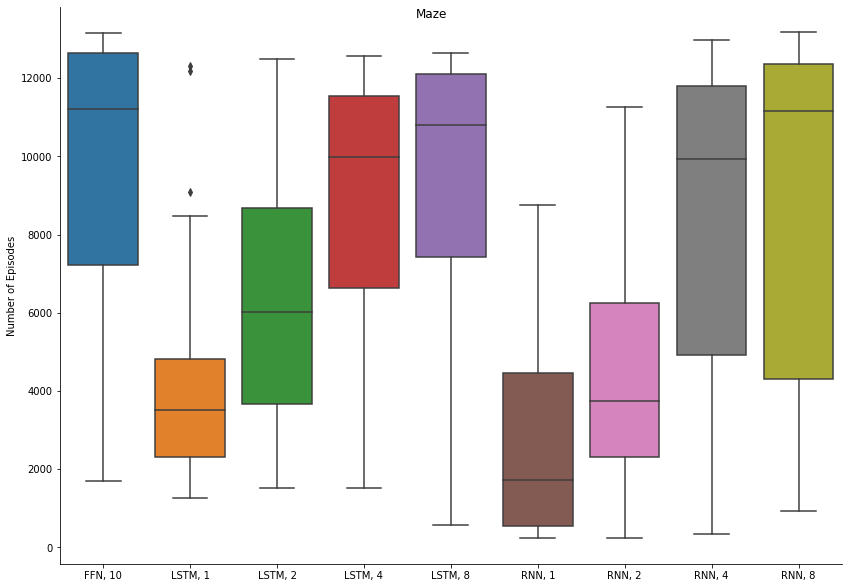

In [110]:
g = sns.catplot(x='Algorithm', y='Num Episodes', data=df_mean[df_mean['Env']=='Maze'], kind='box', sharey=False, height=8.27, aspect=11.7/8.27)
g.set_axis_labels("", "Number of Episodes")
g.fig.suptitle('Maze')
plt.savefig('figures/sensitivity.pdf', bbox_inches='tight')

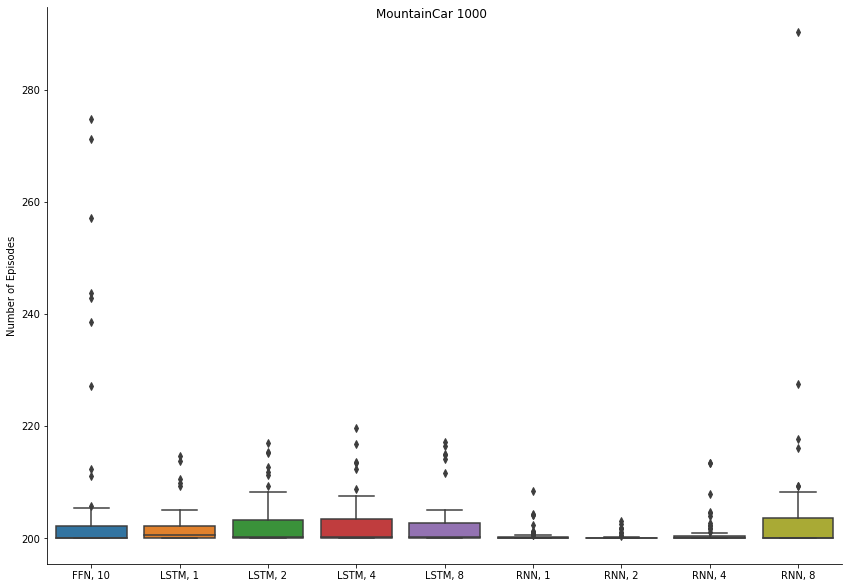

In [113]:
g = sns.catplot(x='Algorithm', y='Num Episodes', data=df_mean[df_mean['Env']=='MountainCar1000-v0'], kind='box', sharey=False, height=8.27, aspect=11.7/8.27)
g.set_axis_labels("", "Number of Episodes")
g.fig.suptitle('MountainCar 1000')
plt.savefig('figures/sensitivity.pdf', bbox_inches='tight')

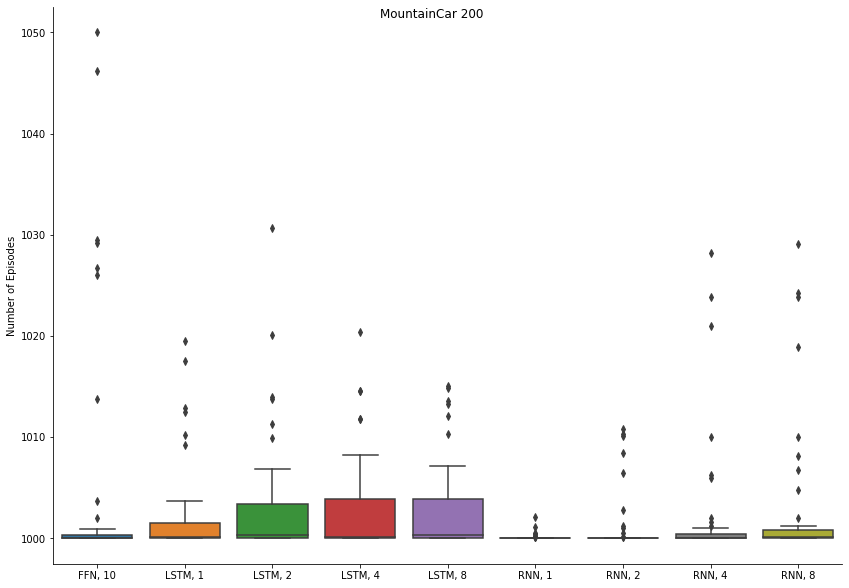

In [114]:
g = sns.catplot(x='Algorithm', y='Num Episodes', data=df_mean[df_mean['Env']=='MountainCar-v0'], kind='box', sharey=False, height=8.27, aspect=11.7/8.27)
g.set_axis_labels("", "Number of Episodes")
g.fig.suptitle('MountainCar 200')
plt.savefig('figures/sensitivity.pdf', bbox_inches='tight')

## Total Number of episodes completed for best hyperparameters

Text(0.5, 0.98, 'Maze')

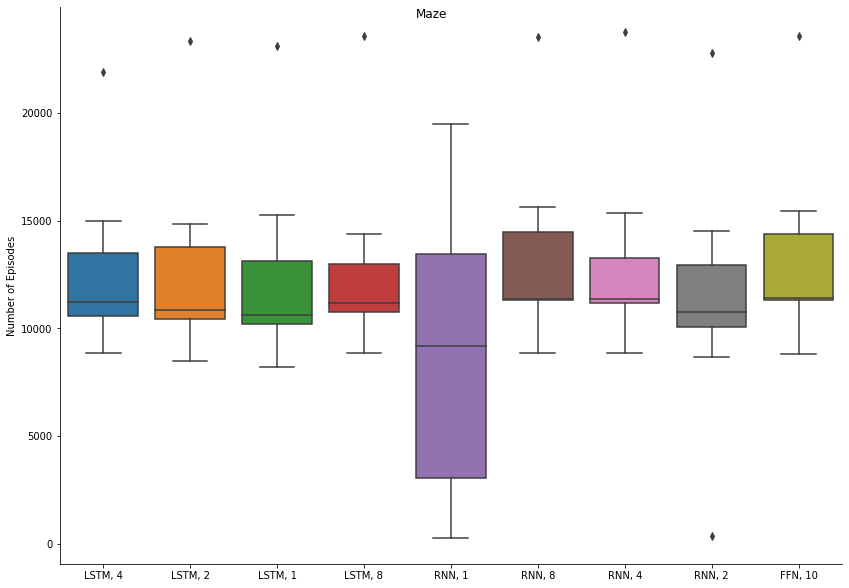

In [118]:
df_best = get_best_data(df, df_mean, columns, 'Num Episodes')
data = df_best[df_best['Env']=='Maze']
g = sns.catplot(x='Algorithm', y='Num Episodes', data=data, kind='box', sharey=False, height=8.27, aspect=11.7/8.27)
g.set_axis_labels("", "Number of Episodes")
g.fig.suptitle('Maze')
# plt.savefig('figures/total_episodes_best_params_lstm.pdf', bbox_inches='tight')

Text(0.5, 0.98, 'Cartpole')

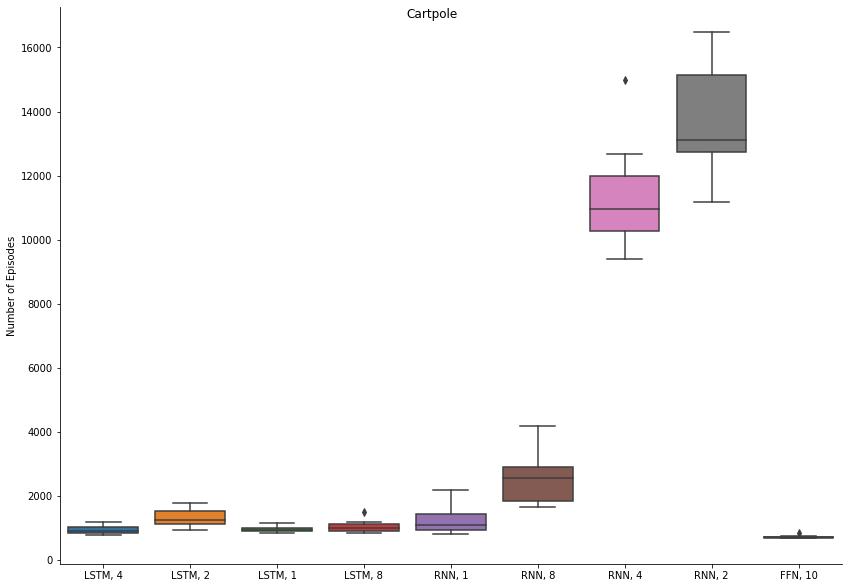

In [121]:
df_best = get_best_data(df, df_mean, columns, 'Num Episodes')
data = df_best[df_best['Env']=='CartPole-v1']
g = sns.catplot(x='Algorithm', y='Num Episodes', data=data, kind='box', sharey=False, height=8.27, aspect=11.7/8.27)
g.set_axis_labels("", "Number of Episodes")
g.fig.suptitle('Cartpole')
# plt.savefig('figures/total_episodes_best_params_lstm.pdf', bbox_inches='tight')

Text(0.5, 0.98, 'MountainCar 1000')

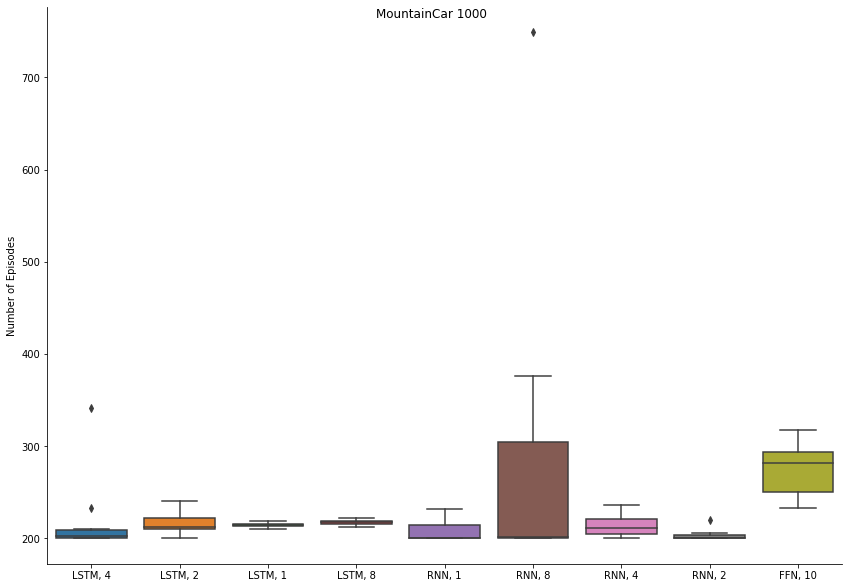

In [123]:
df_best = get_best_data(df, df_mean, columns, 'Num Episodes')
data = df_best[df_best['Env']=='MountainCar1000-v0']
g = sns.catplot(x='Algorithm', y='Num Episodes', data=data, kind='box', sharey=False, height=8.27, aspect=11.7/8.27)
g.set_axis_labels("", "Number of Episodes")
g.fig.suptitle('MountainCar 1000')
# plt.savefig('figures/total_episodes_best_params_lstm.pdf', bbox_inches='tight')

Text(0.5, 0.98, 'MountainCar 200')

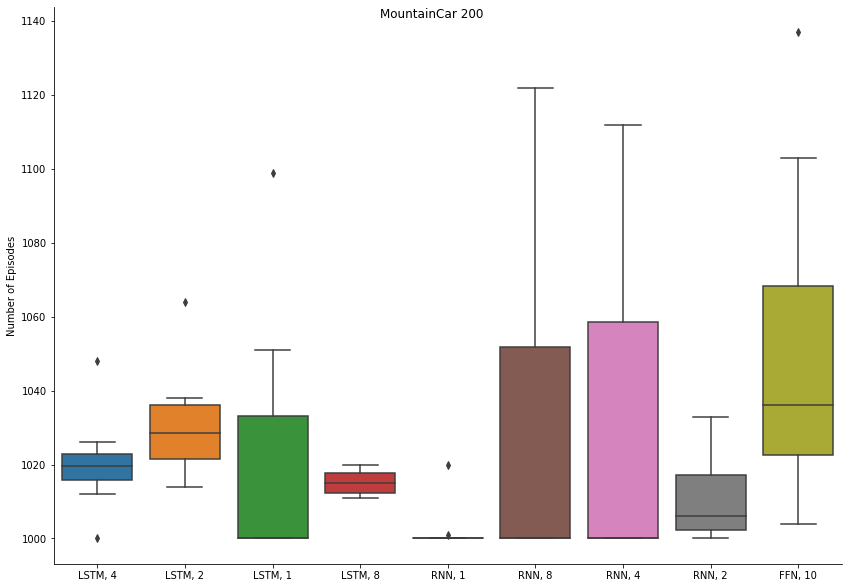

In [125]:
df_best = get_best_data(df, df_mean, columns, 'Num Episodes')
data = df_best[df_best['Env']=='MountainCar-v0']
g = sns.catplot(x='Algorithm', y='Num Episodes', data=data, kind='box', sharey=False, height=8.27, aspect=11.7/8.27)
g.set_axis_labels("", "Number of Episodes")
g.fig.suptitle('MountainCar 200')
# plt.savefig('figures/total_episodes_best_params_lstm.pdf', bbox_inches='tight')

## Average Episode Length for best hyperparameters last 10 episodes

In [129]:
root = Path('results_lstm')
params, num_episodes = extract_episode_lengths(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'], last_n=10)

num_episodes = np.mean(num_episodes, axis=1)

df1 = pd.DataFrame(params)
df2 = pd.DataFrame(num_episodes)
df_lstm = pd.concat([df1, df2], axis=1)
df_lstm = df_lstm.replace('RNN', 'LSTM')

root = Path('results_new_sweep')
params, num_episodes = extract_episode_lengths(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'], last_n=10)

num_episodes = np.mean(num_episodes, axis=1)

df1 = pd.DataFrame(params)
df2 = pd.DataFrame(num_episodes)
df_rnn = pd.concat([df1, df2], axis=1)

df_last = pd.concat([df_lstm, df_rnn])

df_last.columns = ['Model', 'Env', 'Seed', 'Learning Freq.', 'Target Update Freq.', 'L', 'Step Size', 'Buffer Size', 
'Average Episode Length']
df_last = df_last.drop(['Seed'],axis=1)
df_last['Algorithm'] = df_last['Model'] + ', ' + df_last['L'] 
df_last = df_last.drop(['Model', 'L' ], axis=1)

columns = ['Algorithm', 'Env', 'Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'] #parameters

# rename environments
df_last = df_last.replace('envs:random_maze-v0', 'Maze')

Text(0.5, 0.98, 'Maze')

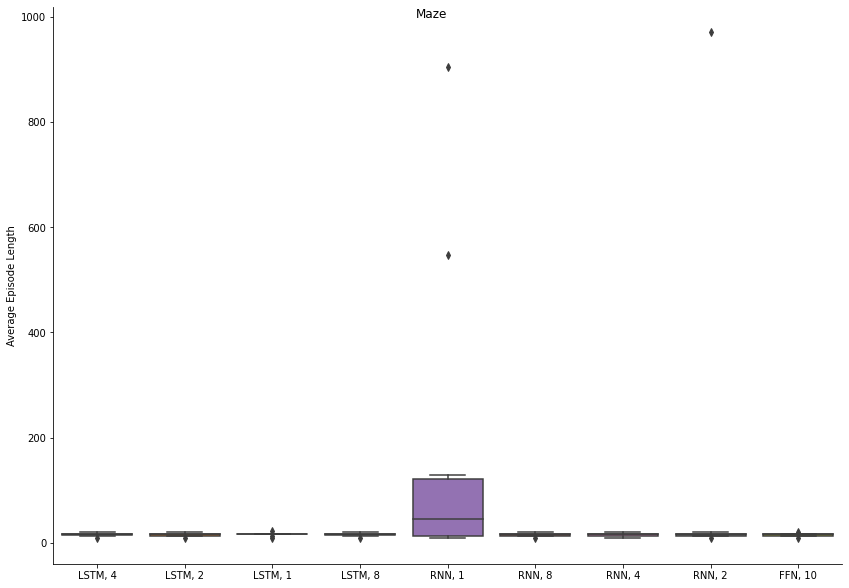

In [132]:
df_best_last = get_best_data(df_last, df_mean, columns, 'Num Episodes') # performance metric for determining best parameters is still num episodes
data = df_best_last[df_best_last['Env']=='Maze']
g = sns.catplot(x='Algorithm', y='Average Episode Length', data=data, kind='box', sharey=False, height=8.27, aspect=11.7/8.27)
g.set_axis_labels("", "Average Episode Length")
g.fig.suptitle('Maze')
# plt.savefig('figures/total_episodes_best_params_lstm.pdf', bbox_inches='tight')

Text(0.5, 0.98, 'CartPole')

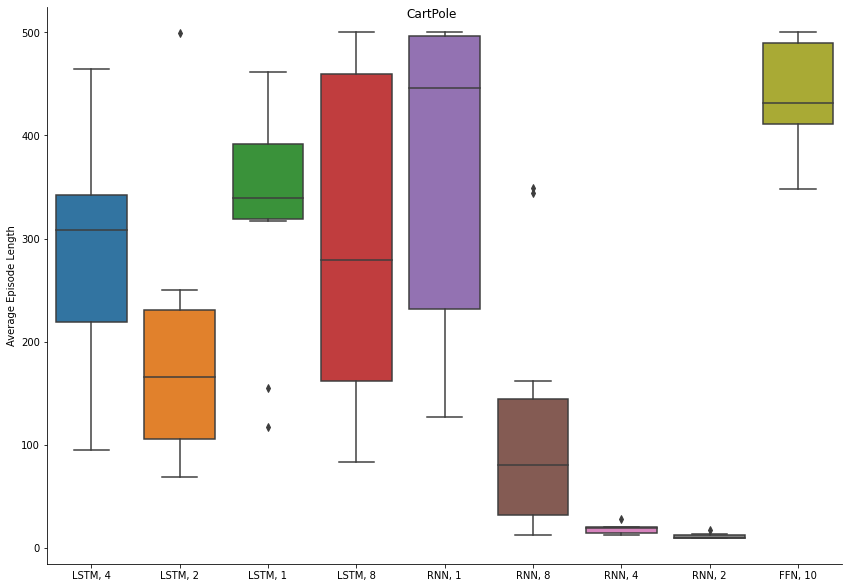

In [134]:
df_best_last = get_best_data(df_last, df_mean, columns, 'Num Episodes') # performance metric for determining best parameters is still num episodes
data = df_best_last[df_best_last['Env']=='CartPole-v1']
g = sns.catplot(x='Algorithm', y='Average Episode Length', data=data, kind='box', sharey=False, height=8.27, aspect=11.7/8.27)
g.set_axis_labels("", "Average Episode Length")
g.fig.suptitle('CartPole')
# plt.savefig('figures/total_episodes_best_params_lstm.pdf', bbox_inches='tight')

Text(0.5, 0.98, 'MountainCar 1000')

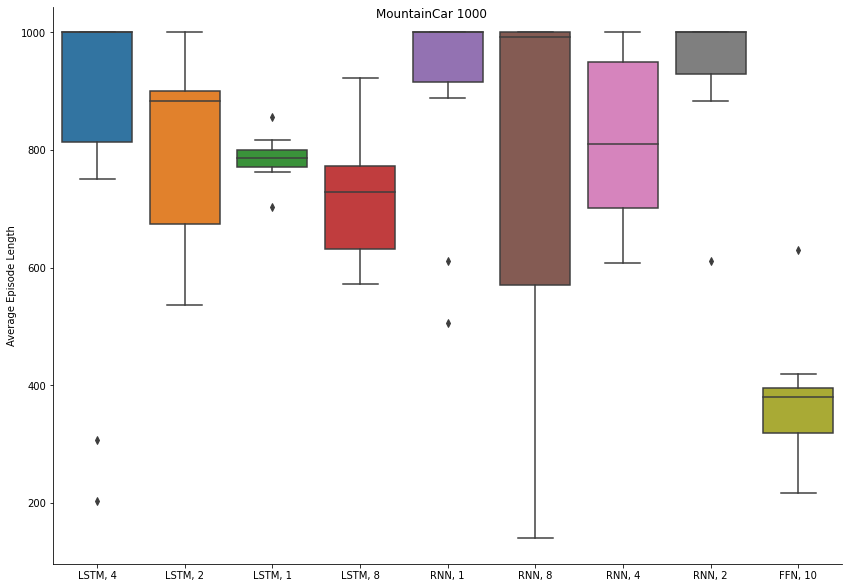

In [135]:
df_best_last = get_best_data(df_last, df_mean, columns, 'Num Episodes') # performance metric for determining best parameters is still num episodes
data = df_best_last[df_best_last['Env']=='MountainCar1000-v0']
g = sns.catplot(x='Algorithm', y='Average Episode Length', data=data, kind='box', sharey=False, height=8.27, aspect=11.7/8.27)
g.set_axis_labels("", "Average Episode Length")
g.fig.suptitle('MountainCar 1000')
# plt.savefig('figures/total_episodes_best_params_lstm.pdf', bbox_inches='tight')

Text(0.5, 0.98, 'MountainCar 200')

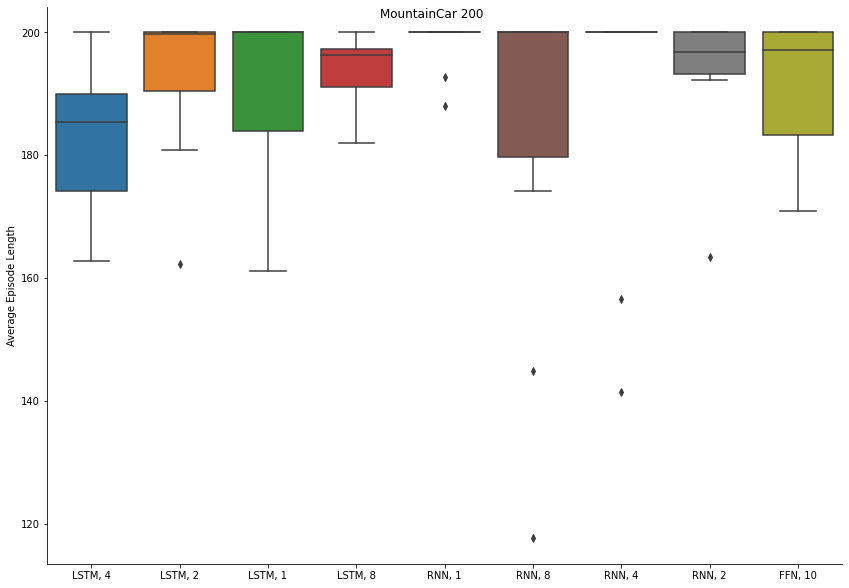

In [136]:
df_best_last = get_best_data(df_last, df_mean, columns, 'Num Episodes') # performance metric for determining best parameters is still num episodes
data = df_best_last[df_best_last['Env']=='MountainCar-v0']
g = sns.catplot(x='Algorithm', y='Average Episode Length', data=data, kind='box', sharey=False, height=8.27, aspect=11.7/8.27)
g.set_axis_labels("", "Average Episode Length")
g.fig.suptitle('MountainCar 200')
# plt.savefig('figures/total_episodes_best_params_lstm.pdf', bbox_inches='tight')